# Đánh giá mô hình trên dữ liệu test

Notebook này thực hiện:
1. Tải mô hình RandomForest đã huấn luyện
2. Xử lý ảnh từ thư mục `/data/test` để trích xuất keypoints
3. Đánh giá độ chính xác của mô hình trên tập test
4. Hiển thị confusion matrix và các metrics đánh giá

In [1]:
# Import các thư viện cần thiết
import os
import sys
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Đường dẫn gốc của dự án
ROOT_PATH = Path('d:/GiaoPhan_Workspace/sem_6/pbl5/baby_posture_analysis')
# Thêm đường dẫn vào sys.path để import các module tự định nghĩa
sys.path.append(str(ROOT_PATH))

# Import các module tự định nghĩa
from app.utils.image_helper import Image_Helper, Image_Rotation_Helper
from app.utils.keypoints_helper import KeypointsExtractorHelper

In [2]:
# Định nghĩa các keypoints quan trọng (sử dụng lại từ notebook 2_extract_keypoints)
IMPORTANT_KEYPOINTS= [
    "nose",
    "left_eye_inner",
    "left_eye",
    "left_eye_outer",
    "right_eye_inner",
    "right_eye",
    "right_eye_outer",
    "left_ear",
    "right_ear",
    "mouth_left",
    "mouth_right",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_pinky",
    "right_pinky",
    "left_index",
    "right_index",
    "left_thumb",
    "right_thumb",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "left_heel",
    "right_heel",
    "left_foot_index",
    "right_foot_index",
]

In [3]:
# Khởi tạo các đối tượng MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Định nghĩa đường dẫn
DATA_TEST_PATH = ROOT_PATH / 'data' / 'test'
MODEL_PATH = ROOT_PATH / 'app' / 'models'
TEMP_CSV_PATH = ROOT_PATH / 'data_cleaned' / 'keypoints_test.csv'

# Danh sách các lớp cần xử lý
CLASSES = ['nam_nghieng', 'nam_ngua', 'nam_sap']

# Map tên lớp sang số
CLASS_MAP = {
    'nam_ngua': 0,
    'nam_nghieng': 1, 
    'nam_sap': 2
   
}


# Map số sang tên lớp
REVERSE_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

In [4]:
# Định nghĩa lớp KeypointExtractor (sử dụng lại từ notebook 2_extract_keypoints)
class KeypointExtractor:
    def __init__(self, mp_pose, important_keypoints):
        """
        Khởi tạo đối tượng KeypointExtractor
        
        Args:
            mp_pose: Đối tượng mp.solutions.pose
            important_keypoints: Danh sách các keypoint quan trọng cần trích xuất
        """
        self.mp_pose = mp_pose
        self.important_keypoints = important_keypoints
        # Khởi tạo pose detector từ MediaPipe
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5
        )
        # Khởi tạo các helper
        self.image_helper = Image_Helper()
        self.image_rotation_helper = Image_Rotation_Helper()
        self.keypoints_helper = KeypointsExtractorHelper(important_keypoints, mp_pose)
    
    def preprocess_image(self, image_path):
        """
        Tiền xử lý ảnh từ đường dẫn
        
        Args:
            image_path: Đường dẫn đến file ảnh
            
        Returns:
            image_rgb: Ảnh đã được tiền xử lý
        """
        try:
            # Đọc ảnh
            image = cv2.imread(str(image_path))
            
            # Kiểm tra xem ảnh có phải là ảnh grayscale không
            if len(image.shape) == 2 or image.shape[2] == 1:
                # Chuyển đổi grayscale sang RGB
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
            # Chuyển đổi ảnh sang định dạng vuông
            image_squared, new_size = self.image_helper.square_image(image)
            
            # Chuyển đổi ảnh sang RGB (MediaPipe yêu cầu RGB)
            image_rgb = cv2.cvtColor(image_squared, cv2.COLOR_BGR2RGB)
            
            return image_rgb
        except Exception as e:
            print(f"Lỗi tiền xử lý ảnh {image_path}: {str(e)}")
            return None
    
    def extract_keypoints(self, image):
        """
        Trích xuất keypoints từ ảnh
        
        Args:
            image: Ảnh cần trích xuất keypoints
            
        Returns:
            df_keypoints: DataFrame chứa các keypoints đã được trích xuất
            results: Kết quả trích xuất từ MediaPipe
        """
        try:
            # Xử lý ảnh với MediaPipe Pose
            results = self.pose.process(image)
            
            # Kiểm tra xem có phát hiện được pose không
            if not results.pose_landmarks:
                return None, None
            
            # Chuẩn hóa hướng của pose
            results.pose_landmarks = self.image_rotation_helper.rotate_image_baby(results.pose_landmarks)
            
            # Trích xuất và chuẩn hóa các keypoints sử dụng helper
            df_keypoints = self.keypoints_helper.process_keypoints(results.pose_landmarks.landmark)
            
            return df_keypoints, results
        except Exception as e:
            print(f"Lỗi trích xuất keypoints: {str(e)}")
            return None, None
    
    def process_image(self, image_path, label=None):
        """
        Xử lý ảnh và trích xuất keypoints
        
        Args:
            image_path: Đường dẫn đến file ảnh
            label: Nhãn của ảnh (tên lớp)
            
        Returns:
            df_keypoints: DataFrame chứa các keypoints đã được trích xuất
        """
        # Tiền xử lý ảnh
        image = self.preprocess_image(image_path)
        
        if image is None:
            return None
        
        # Trích xuất keypoints
        df_keypoints, results = self.extract_keypoints(image)
        
        if df_keypoints is None:
            return None
        
        # Thêm nhãn vào kết quả nếu có
        if label is not None:
            df_keypoints['label'] = label
            
        return df_keypoints
    
    def visualize_pose(self, image, results):
        """
        Hiển thị pose đã được phát hiện trên ảnh
        
        Args:
            image: Ảnh gốc
            results: Kết quả từ MediaPipe Pose
            
        Returns:
            annotated_image: Ảnh với pose được chú thích
        """
        if results is None or not results.pose_landmarks:
            return image
        
        # Copy ảnh để vẽ trên đó
        annotated_image = image.copy()
        
        # Vẽ landmarks
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        return annotated_image

In [5]:
# Hàm để trích xuất keypoints từ tập test
def extract_keypoints_from_test_dataset():
    """
    Xử lý và trích xuất keypoints từ tất cả ảnh trong tập test
    
    Returns:
        final_df: DataFrame chứa keypoints từ tất cả ảnh đã xử lý thành công
        stats: Dictionary chứa thống kê về quá trình xử lý
    """
    # Khởi tạo đối tượng KeypointExtractor
    extractor = KeypointExtractor(mp_pose, IMPORTANT_KEYPOINTS)
    
    # Danh sách DataFrame để lưu trữ kết quả
    dfs = []
    
    # Biến đếm tổng số ảnh và số ảnh được xử lý thành công
    total_images = 0
    successful_images = 0
    failed_images = {}
    
    # Chuẩn bị hình ảnh mẫu để hiển thị
    sample_images = {}
    
    # Duyệt qua từng lớp và xử lý các ảnh
    for class_name in CLASSES:
        class_path = DATA_TEST_PATH / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        
        print(f"Đang xử lý {len(image_files)} ảnh trong lớp '{class_name}'")
        total_images += len(image_files)
        failed_images[class_name] = 0
        
        # Lựa chọn một ảnh mẫu để hiển thị
        if image_files:
            sample_image_path = image_files[0]  # Lấy ảnh đầu tiên làm mẫu
            sample_image = extractor.preprocess_image(sample_image_path)
            
            if sample_image is not None:
                df_keypoints, results = extractor.extract_keypoints(sample_image)
                
                if results is not None:
                    # Vẽ pose lên ảnh mẫu
                    annotated_image = extractor.visualize_pose(sample_image, results)
                    sample_images[class_name] = annotated_image
        
        # Xử lý tất cả các ảnh trong lớp
        for image_path in tqdm(image_files, desc=f"Lớp {class_name}"):
            try:
                # Trích xuất keypoints từ ảnh 
                df_keypoints = extractor.process_image(image_path, CLASS_MAP[class_name])
                
                if df_keypoints is not None:
                    dfs.append(df_keypoints)
                    successful_images += 1
                else:
                    failed_images[class_name] += 1
            except Exception as e:
                print(f"Lỗi xử lý file {image_path}: {str(e)}")
                failed_images[class_name] += 1
    
    # Tạo DataFrame cuối cùng từ tất cả kết quả
    final_df = pd.concat(dfs, ignore_index=True) if dfs else None
    
    # Thống kê kết quả
    stats = {
        'total_images': total_images,
        'successful_images': successful_images,
        'success_rate': successful_images/total_images*100 if total_images > 0 else 0,
        'failed_images': failed_images,
        'sample_images': sample_images
    }
    
    return final_df, stats

In [6]:
# Hàm hiển thị ảnh mẫu với pose được phát hiện
def visualize_sample_poses(sample_images):
    """
    Hiển thị ảnh mẫu với pose được phát hiện
    
    Args:
        sample_images: Dictionary chứa ảnh mẫu cho mỗi lớp
    """
    plt.figure(figsize=(15, 10))
    
    for idx, (class_name, image) in enumerate(sample_images.items()):
        plt.subplot(1, len(sample_images), idx+1)
        plt.imshow(image)
        plt.title(f'Mẫu lớp {class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Bắt đầu trích xuất keypoints từ tập test...
Đang xử lý 27 ảnh trong lớp 'nam_nghieng'


Lớp nam_nghieng: 100%|██████████| 27/27 [00:04<00:00,  6.50it/s]



Đang xử lý 32 ảnh trong lớp 'nam_ngua'


Lớp nam_ngua: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]



Đang xử lý 30 ảnh trong lớp 'nam_sap'


Lớp nam_sap: 100%|██████████| 30/30 [00:04<00:00,  6.90it/s]




Tổng số ảnh test: 89
Số ảnh xử lý thành công: 83
Tỉ lệ thành công: 93.26%

Số ảnh thất bại theo lớp:
- nam_nghieng: 2 ảnh
- nam_ngua: 0 ảnh
- nam_sap: 4 ảnh

Đã lưu dữ liệu keypoints test vào file d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_analysis\data_cleaned\keypoints_test.csv
Kích thước dữ liệu test: (83, 100)
Số lượng mẫu theo lớp:
- nam_ngua: 32
- nam_nghieng: 25
- nam_sap: 26


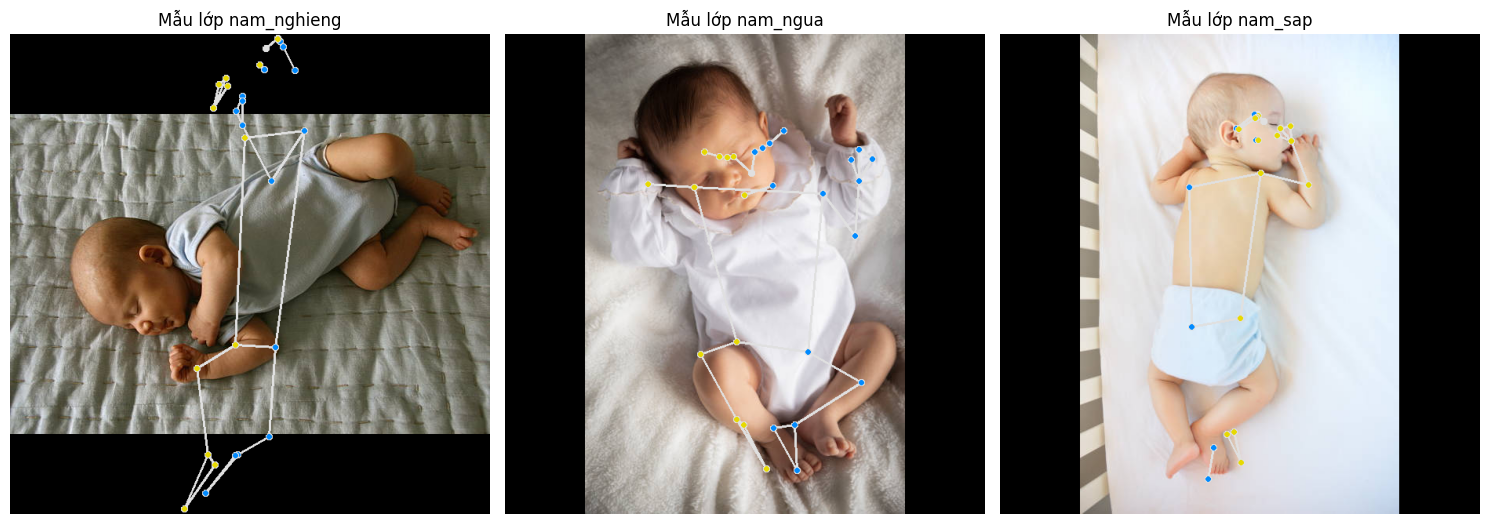

In [7]:
# Thực hiện trích xuất keypoints từ tập test
print("Bắt đầu trích xuất keypoints từ tập test...")
test_df, test_stats = extract_keypoints_from_test_dataset()

# Hiển thị thông tin về quá trình xử lý
print(f"\nTổng số ảnh test: {test_stats['total_images']}")
print(f"Số ảnh xử lý thành công: {test_stats['successful_images']}")
print(f"Tỉ lệ thành công: {test_stats['success_rate']:.2f}%")
print("\nSố ảnh thất bại theo lớp:")
for class_name, count in test_stats['failed_images'].items():
    print(f"- {class_name}: {count} ảnh")

# Lưu DataFrame keypoints test vào file CSV
if test_df is not None:
    test_df.to_csv(TEMP_CSV_PATH, index=False)
    print(f"\nĐã lưu dữ liệu keypoints test vào file {TEMP_CSV_PATH}")
    
    # Hiển thị thông tin về dữ liệu test
    print(f"Kích thước dữ liệu test: {test_df.shape}")
    print(f"Số lượng mẫu theo lớp:")
    for class_name, label in CLASS_MAP.items():
        print(f"- {class_name}: {len(test_df[test_df['label'] == label])}")

# Hiển thị ảnh mẫu với pose được phát hiện
visualize_sample_poses(test_stats['sample_images'])

In [8]:
# Load mô hình đã được huấn luyện và scaler
def load_model(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    return model

# Đường dẫn đến các file mô hình
scaler_path = MODEL_PATH / 'input_scaler.pkl'
model_path = MODEL_PATH / 'random_forest.pkl'

# Load scaler và mô hình
try:
    scaler = load_model(scaler_path)
    model = load_model(model_path)
    print("Đã load thành công mô hình và scaler")
except Exception as e:
    print(f"Lỗi khi load mô hình: {str(e)}")

Đã load thành công mô hình và scaler


In [9]:
test_df.head(5)

,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,left_eye_outer_x,...,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,label
0,0.002568,-0.451889,-0.267812,0.029727,-0.476324,-0.266519,0.036025,-0.467887,-0.266986,0.042934,...,-0.117668,0.529629,0.008493,-0.139726,0.596152,0.187123,-0.190171,0.631869,0.000539,1
1,-0.111634,-0.426227,-0.053973,-0.078148,-0.452239,-0.081819,-0.069564,-0.450418,-0.082022,-0.060585,...,-0.032056,0.943258,0.196457,-0.629474,0.327977,0.460009,-0.102868,0.895367,0.175210,1
2,0.163236,-0.425451,-0.137363,0.134242,-0.453854,-0.118843,0.127441,-0.450303,-0.119295,0.119769,...,0.105684,0.658887,-0.236155,0.439308,0.486721,0.443214,0.290759,0.590134,-0.246990,1
3,-0.067744,-0.338456,0.026433,-0.058615,-0.377754,-0.029859,-0.054920,-0.378741,-0.030268,-0.051140,...,-0.201134,0.540232,0.117135,-0.257035,0.331340,-0.083939,-0.242391,0.430754,0.058295,1
4,0.054320,-0.448934,-0.268972,0.039498,-0.486089,-0.226760,0.039319,-0.489010,-0.227458,0.039395,...,0.197562,0.587595,-0.499797,0.253074,0.483951,0.364760,0.262995,0.505055,-0.507890,1


In [10]:
# Chuẩn bị dữ liệu test
X_test = test_df.drop(columns="label")
y_test = test_df["label"]

In [11]:
y_test.unique()

array([1, 0, 2], dtype=int64)

Accuracy trên tập test: 0.9518 (95.18%)

Classification Report:
              precision    recall  f1-score   support

    nam_ngua       0.97      1.00      0.98        32
 nam_nghieng       0.96      0.88      0.92        25
     nam_sap       0.93      0.96      0.94        26

    accuracy                           0.95        83
   macro avg       0.95      0.95      0.95        83
weighted avg       0.95      0.95      0.95        83



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


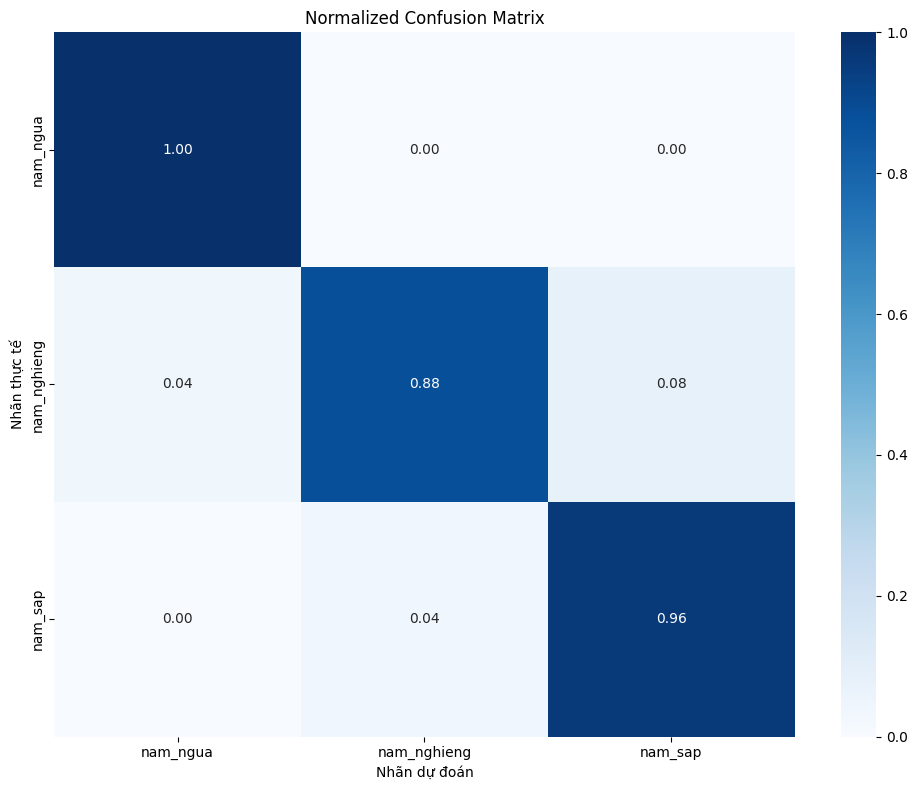

In [12]:
# Thực hiện chuẩn hóa dữ liệu test
X_test_scaled = scaler.transform(X_test)

# Dự đoán với mô hình
y_pred = model.predict(X_test_scaled)

# Tính toán accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy trên tập test: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Hiển thị classification report
print("\nClassification Report:")
class_names = [REVERSE_CLASS_MAP[i] for i in sorted(REVERSE_CLASS_MAP.keys())]
print(classification_report(y_test, y_pred, target_names=class_names))

# Tính toán confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Chuẩn hóa confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Hiển thị confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.tight_layout()
plt.show()

In [13]:
# Phân tích các mẫu dự đoán sai
incorrect_indices = np.where(y_test != y_pred)[0]
if len(incorrect_indices) > 0:
    print(f"Số lượng mẫu dự đoán sai: {len(incorrect_indices)}")
    
    # Tạo DataFrame chứa thông tin về các mẫu dự đoán sai
    incorrect_df = pd.DataFrame({
        'Actual': [REVERSE_CLASS_MAP[y_test.iloc[i]] for i in incorrect_indices],
        'Predicted': [REVERSE_CLASS_MAP[y_pred[i]] for i in incorrect_indices]
    })
    
    # Hiển thị thống kê các lỗi dự đoán
    print("\nPhân bố các lỗi dự đoán:")
    error_counts = incorrect_df.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
    print(error_counts)
else:
    print("Không có mẫu nào bị dự đoán sai!")

Số lượng mẫu dự đoán sai: 4

Phân bố các lỗi dự đoán:
        Actual    Predicted  Count
0  nam_nghieng     nam_ngua      1
1  nam_nghieng      nam_sap      2
2      nam_sap  nam_nghieng      1


Đã tìm thấy 4 ảnh bị dự đoán sai.


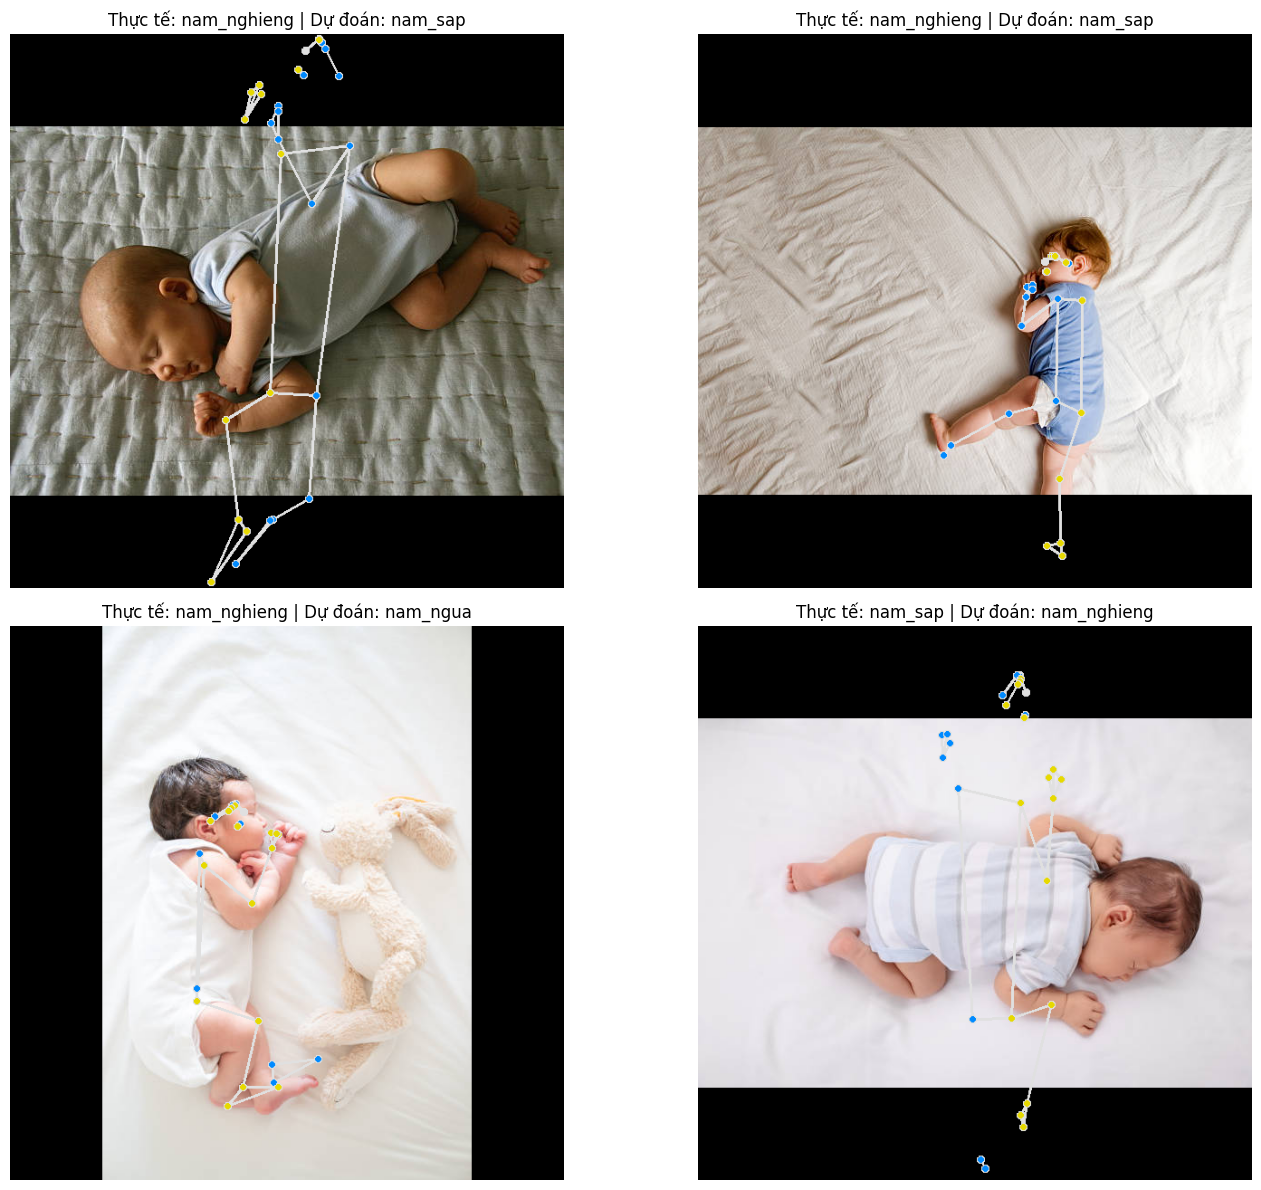


Thông tin chi tiết về các ảnh bị dự đoán sai:


,index,actual_label,predicted_label,image_path
0,7,nam_nghieng,nam_sap,d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_...
1,13,nam_nghieng,nam_sap,d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_...
2,14,nam_nghieng,nam_ngua,d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_...
3,72,nam_sap,nam_nghieng,d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_...


In [14]:
# Hiển thị các ảnh dự đoán sai
def visualize_misclassified_images():
    """
    Tìm và hiển thị các ảnh được dự đoán sai từ tập test
    Giúp phân tích trực quan để hiểu nguyên nhân mô hình dự đoán sai
    """
    # Khởi tạo đối tượng KeypointExtractor để xử lý ảnh
    extractor = KeypointExtractor(mp_pose, IMPORTANT_KEYPOINTS)
    
    # DataFrame để lưu thông tin về các ảnh dự đoán sai
    misclassified_info = []
    
    # Tìm các mẫu dự đoán sai
    incorrect_indices = np.where(y_test != y_pred)[0]
    
    if len(incorrect_indices) == 0:
        print("Không có ảnh nào bị dự đoán sai!")
        return
    
    print(f"Đã tìm thấy {len(incorrect_indices)} ảnh bị dự đoán sai.")
    
    # Giới hạn số lượng ảnh hiển thị (để tránh quá nhiều ảnh)
    max_images_to_show = min(10, len(incorrect_indices))
    selected_indices = incorrect_indices[:max_images_to_show]
    
    # Tạo một figure lớn để hiển thị các ảnh
    fig = plt.figure(figsize=(15, 5 * (len(selected_indices)+1)//2))
    
    # Duyệt qua từng mẫu đã chọn
    for i, idx in enumerate(selected_indices):
        actual_label = y_test.iloc[idx]
        predicted_label = y_pred[idx]
        
        # Tìm tên class tương ứng
        actual_class = REVERSE_CLASS_MAP[actual_label]
        predicted_class = REVERSE_CLASS_MAP[predicted_label]
        
        # Tìm các mẫu tương ứng trong DATA_TEST_PATH
        test_path = DATA_TEST_PATH / actual_class
        image_files = list(test_path.glob('*.jpg')) + list(test_path.glob('*.png')) + list(test_path.glob('*.jpeg'))
        
        if not image_files:
            continue
            
        # Chọn một ảnh để hiển thị (đây là phần cần cải tiến khi có mapping chính xác giữa keypoints và ảnh)
        image_path = image_files[i % len(image_files)]  # Đây là giải pháp tạm thời
        
        # Xử lý ảnh
        image = extractor.preprocess_image(image_path)
        
        if image is None:
            continue
            
        # Trích xuất keypoints
        _, results = extractor.extract_keypoints(image)
        
        if results is None:
            continue
            
        # Vẽ pose lên ảnh
        annotated_image = extractor.visualize_pose(image, results)
        
        # Thêm subplot
        ax = fig.add_subplot(math.ceil(len(selected_indices)/2), 2, i+1)
        ax.imshow(annotated_image)
        
        # Thêm tiêu đề với thông tin dự đoán
        ax.set_title(f"Thực tế: {actual_class} | Dự đoán: {predicted_class}", fontsize=12)
        ax.axis('off')
        
        # Lưu thông tin để phân tích
        misclassified_info.append({
            'index': idx,
            'actual_label': actual_class,
            'predicted_label': predicted_class,
            'image_path': str(image_path)
        })
    
    plt.tight_layout()
    plt.show()
    
    # Hiển thị bảng thông tin
    misclassified_df = pd.DataFrame(misclassified_info)
    print("\nThông tin chi tiết về các ảnh bị dự đoán sai:")
    display(misclassified_df)
    
    return misclassified_df

# Thêm import module math
import math

# Chạy hàm hiển thị ảnh sai
misclassified_df = visualize_misclassified_images()

## Kết luận

Notebook này đã thực hiện việc:

1. Trích xuất keypoints từ ảnh trong tập test
2. Load mô hình đã huấn luyện và chuẩn hóa dữ liệu test
3. Đánh giá mô hình trên tập test với các metrics: accuracy, precision, recall, f1-score
4. Hiển thị confusion matrix để phân tích kết quả chi tiết
5. Phân tích các trường hợp dự đoán sai

Kết quả của mô hình RandomForest trên tập test được hiển thị ở trên.